In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.compare import compare_survival
from sksurv.datasets import get_x_y

In [2]:
df_tcga_clinical = pd.read_csv("/home/cke/TCGA_HNSCC_clinical_data.tsv",sep='\t')

In [3]:
df_tcga_clinical

,Study ID,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Alcohol Consumption Frequency,...,Specimen Second Longest Dimension,Stage Other,Time between clamping and freezing,Time between excision and freezing,Tissue Source Site,Patient Smoking History Category,Primary Therapy Outcome Success Type,Person Neoplasm Status,Vial number,Patient's Vital Status
0,hnsc_tcga,TCGA-4P-AA8J,TCGA-4P-AA8J-01,66.0,MX,N2c,Stage IVA,7th,T2,NaN,...,NaN,NaN,NaN,NaN,4P,[Unknown],Complete Remission/Response,TUMOR FREE,A,Alive
1,hnsc_tcga,TCGA-BA-4074,TCGA-BA-4074-01,69.0,M0,N2c,Stage IVA,6th,T2,NaN,...,0.7,NaN,NaN,NaN,BA,2,NaN,WITH TUMOR,A,Dead
2,hnsc_tcga,TCGA-BA-4075,TCGA-BA-4075-01,49.0,M0,N0,Stage III,6th,T3,7.0,...,0.7,NaN,NaN,NaN,BA,2,NaN,WITH TUMOR,A,Dead
3,hnsc_tcga,TCGA-BA-4076,TCGA-BA-4076-01,39.0,NaN,NX,NaN,6th,TX,NaN,...,0.6,NaN,NaN,NaN,BA,2,NaN,WITH TUMOR,A,Dead
4,hnsc_tcga,TCGA-BA-4077,TCGA-BA-4077-01,45.0,M0,N0,Stage IVA,6th,T4a,0.0,...,0.5,NaN,NaN,NaN,BA,4,NaN,WITH TUMOR,B,Dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,hnsc_tcga,TCGA-UF-A7JT,TCGA-UF-A7JT-01,72.0,M0,N0,Stage IVA,6th,T4a,NaN,...,NaN,NaN,NaN,NaN,UF,1,Complete Remission/Response,WITH TUMOR,A,Dead
526,hnsc_tcga,TCGA-UF-A7JV,TCGA-UF-A7JV-01,62.0,M0,N2b,Stage IVA,7th,T4a,NaN,...,NaN,NaN,NaN,NaN,UF,1,Complete Remission/Response,WITH TUMOR,A,Dead
527,hnsc_tcga,TCGA-UP-A6WW,TCGA-UP-A6WW-01,58.0,NaN,NaN,NaN,7th,NaN,7.0,...,NaN,NaN,NaN,NaN,UP,1,Complete Remission/Response,TUMOR FREE,A,Alive
528,hnsc_tcga,TCGA-WA-A7GZ,TCGA-WA-A7GZ-01,58.0,NaN,N0,NaN,7th,T2,NaN,...,NaN,NaN,NaN,NaN,WA,2,Complete Remission/Response,TUMOR FREE,A,Dead


In [4]:
df_tcga_survival = df_tcga_clinical.loc[:,['Patient ID','Overall Survival (Months)','Overall Survival Status']]
# df_tcga_survival

In [5]:
df_tcga_survival.dropna(inplace=True)
df_tcga_survival

,Patient ID,Overall Survival (Months),Overall Survival Status
0,TCGA-4P-AA8J,3.35,LIVING
1,TCGA-BA-4074,15.18,DECEASED
2,TCGA-BA-4075,9.30,DECEASED
3,TCGA-BA-4076,13.63,DECEASED
4,TCGA-BA-4077,37.25,DECEASED
...,...,...,...
525,TCGA-UF-A7JT,32.62,DECEASED
526,TCGA-UF-A7JV,2.96,DECEASED
527,TCGA-UP-A6WW,17.02,LIVING
528,TCGA-WA-A7GZ,20.53,DECEASED


## Prepare df_merged as in pipeline_downstream_analysis-show


In [6]:
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top100DEGs.csv",index_col=0)
res_prevail['sample'] = res_prevail.index.tolist()
res_prevail['sample'] = res_prevail['sample'].str.rstrip('A')
# res_prevail
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail_subtypes = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_ImmuneSubtypes_real_top100DEGs_Aug8.csv",index_col=0)
res_prevail_subtypes['sample'] = res_prevail_subtypes.index.tolist()
res_prevail_subtypes['sample'] = res_prevail_subtypes['sample'].str.rstrip('A')
# res_prevail_subtypes
# read in fga data table from Kari's plots
fga_Kari = pd.read_csv("/home/cke/KariPDF/fga_table.csv",header=None)
fga_Kari.columns = ['sample','fga']
# using cellularity extracted from Kari's plots pdf 
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
# cellularity_Kari
# fga_Kari
df_merged = pd.merge(res_prevail,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
df_merged_subtypes = pd.merge(res_prevail_subtypes,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
# Merging fga + cell type fractions 

In [7]:
def define_FGA(fga):
    if fga > 0.2:
        return 'High'
    else:
        return 'Silent'
df_merged['FGA_status'] = df_merged['fga'].apply(define_FGA)
df_merged_subtypes['FGA_status'] = df_merged_subtypes['fga'].apply(define_FGA)

Nulton = pd.read_excel("/home/cke/Nulton 2017 - supplementary.xlsx",sheet_name=1)
# Nulton
TCGA_pheno = pd.read_csv("/home/cke/TCGA-HNSC.GDC_phenotype.tsv",sep='\t')
TCGA_pheno['hpv_status']=''
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Positive'),'hpv_status']='Positive'
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Negative') & (TCGA_pheno['hpv_status_by_p16_testing']=='Negative'),'hpv_status']='Negative'
# TCGA_pheno['hpv_status'].value_counts()
TCGA_pheno['sample'] = TCGA_pheno['submitter_id.samples'].str.rsplit("-",n=1,expand=True)[0]
list_pos_tcgaPheno = TCGA_pheno[TCGA_pheno['hpv_status']=='Positive']['sample'].tolist()
list_pos_Nulton = Nulton['HNSCC Barcode'].tolist()
# remove conflict samples between TCGA annotation and Nulton et al.
list_remove = []
for i in list_pos_tcgaPheno:
    if i not in list_pos_Nulton:
        list_remove.append(i)
# list_remove

/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
set_pos = list_pos_Nulton
print("We gathered",len(list_pos_Nulton),"Positive samples from two source") 
print("We removed",len(list_remove),"conflicting samples") 

We gathered 72 Positive samples from two source
We removed 10 conflicting samples


In [9]:
dict_primary_site = {'Alveolar Ridge': 'Oral Cavity',
 'Floor of mouth': 'Oral Cavity',
 'Palate': 'Oral Cavity',
 'Lip': 'Oral Cavity',
 'Oral Tongue': 'Oral Cavity',
 'Oral Cavity': 'Oral Cavity',
 'Other and unspecified parts of tongue': 'Oral Cavity',
 'Other and unspecified parts of mouth': 'Oral Cavity',
 'Base of tongue': 'Oropharynx',
 'Tonsil': 'Oropharynx',
 'Oropharynx': 'Oropharynx',
    'Larynx': 'Larynx',    
    'Floor of mouth':'Oral Cavity',
    'Gum':'Oral Cavity',
    'Oropharynx':'Oropharynx',
    'Hypopharynx':'Hypopharynx',}
TCGA_pheno_new = TCGA_pheno.copy()
TCGA_pheno_new['primary_site'] = TCGA_pheno_new['primary_site'].map(dict_primary_site)
TCGA_pheno_new.dropna(subset='primary_site',inplace=True)

#Selecting only primary tumor!
TCGA_pheno_new = TCGA_pheno_new[TCGA_pheno_new['sample_type.samples']=='Primary Tumor']
TCGA_pheno_new['primary_site'].value_counts()

df_merged['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_sites = pd.merge(df_merged,TCGA_pheno_new[['sample','primary_site']],left_on='sample_match',right_on='sample')
# df_merged_sites

df_merged_subtypes['sample_match'] = df_merged_subtypes['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_subtypes_sites = pd.merge(df_merged_subtypes,TCGA_pheno_new[['sample','primary_site']],left_on='sample_match',right_on='sample')
# df_merged_subtypes_sites

In [10]:
df_merged_sites = pd.merge(df_merged_sites,df_tcga_survival,left_on='sample_match',right_on='Patient ID',how='left')
df_merged_subtypes_sites = pd.merge(df_merged_subtypes_sites,df_tcga_survival,left_on='sample_match',right_on='Patient ID',how='left')

In [11]:
df_merged_HPVpos = df_merged_sites.copy()
df_merged_HPVpos = df_merged_HPVpos[df_merged_HPVpos['sample_match'].isin(set_pos)]
df_merged_HPVpos['hpv_status'] = "Positive"
# df_merged_HPVpos
print(df_merged_HPVpos.shape[0])
df_merged_HPVneg = df_merged_sites.copy()
df_merged_HPVneg = df_merged_HPVneg[~df_merged_HPVneg['sample_match'].isin(set_pos) & ~df_merged_HPVneg['sample_match'].isin(list_remove)]
df_merged_HPVneg['hpv_status'] = "Negative"
# df_merged_HPVneg
print(df_merged_HPVneg.shape[0])
df_merged_HPVpos_subtypes = df_merged_subtypes_sites.copy()
df_merged_HPVpos_subtypes = df_merged_HPVpos_subtypes[df_merged_HPVpos_subtypes['sample_match'].isin(set_pos)]
df_merged_HPVpos_subtypes['hpv_status'] = "Positive"
# df_merged_HPVpos
print(df_merged_HPVpos_subtypes.shape[0])
df_merged_HPVneg_subtypes = df_merged_subtypes_sites.copy()
df_merged_HPVneg_subtypes = df_merged_HPVneg_subtypes[~df_merged_HPVneg_subtypes['sample_match'].isin(set_pos) & ~df_merged_HPVneg_subtypes['sample_match'].isin(list_remove)]
df_merged_HPVneg_subtypes['hpv_status'] = "Negative"
# df_merged_HPVneg
print(df_merged_HPVneg_subtypes.shape[0])
# Ultimate dataframe containing all information
df_merged_nonrelative = pd.concat([df_merged_HPVpos,df_merged_HPVneg])
df_merged_subtypes_nonrelative = pd.concat([df_merged_HPVpos_subtypes,df_merged_HPVneg_subtypes])

60
354
60
354


In [17]:
df_merged_nonrelative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,...,cellularity,fga,FGA_status,sample_match,sample_y,primary_site,Patient ID,Overall Survival (Months),Overall Survival Status,hpv_status
2,5.709435e-03,0.003259,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,...,0.36,0.572,High,TCGA-CN-5374,TCGA-CN-5374,Oropharynx,TCGA-CN-5374,56.90,DECEASED,Positive
6,8.058788e-03,0.004823,0.053060,0.050577,0.088309,0.001369,9.219069e-07,1.354588e-06,0.031462,0.762338,...,0.48,0.098,Silent,TCGA-CR-5249,TCGA-CR-5249,Oropharynx,TCGA-CR-5249,37.84,LIVING,Positive
24,3.396785e-03,0.041641,0.040713,0.013894,0.158393,0.000163,6.779418e-04,1.593186e-06,0.041585,0.699535,...,0.66,0.245,High,TCGA-CV-6433,TCGA-CV-6433,Oral Cavity,TCGA-CV-6433,21.06,LIVING,Positive
33,9.403402e-03,0.003327,0.024324,0.302406,0.185639,0.000672,9.655291e-07,1.128296e-06,0.020712,0.453513,...,0.27,0.436,High,TCGA-H7-A76A,TCGA-H7-A76A,Oropharynx,TCGA-H7-A76A,20.93,LIVING,Positive
41,1.096958e-02,0.048059,0.060456,0.054257,0.097379,0.000084,5.340647e-03,1.951452e-06,0.038107,0.685345,...,0.56,0.542,High,TCGA-BB-4225,TCGA-BB-4225,Oropharynx,TCGA-BB-4225,4.80,LIVING,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,4.269644e-05,0.000016,0.018005,0.019971,0.009111,0.000082,7.632417e-03,3.212852e-04,0.002373,0.942446,...,0.63,0.562,High,TCGA-C9-A47Z,TCGA-C9-A47Z,Oral Cavity,TCGA-C9-A47Z,6.27,DECEASED,Negative
413,6.054611e-03,0.000002,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,...,0.36,0.736,High,TCGA-CN-6010,TCGA-CN-6010,Larynx,TCGA-CN-6010,50.03,LIVING,Negative
414,2.447322e-07,0.000006,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,...,0.40,0.778,High,TCGA-CV-7235,TCGA-CV-7235,Oral Cavity,TCGA-CV-7235,77.10,LIVING,Negative
415,1.076841e-03,0.000132,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,...,0.61,0.642,High,TCGA-CX-7086,TCGA-CX-7086,Oral Cavity,TCGA-CX-7086,18.82,LIVING,Negative


In [18]:
df_merged_subtypes_nonrelative

,B-cells,CD14-cells,CD8-cells,Endothelial,Fibroblast,Macrophage,Mast,NK-cells,pDC-cells,Tconv-cell,...,cellularity,fga,FGA_status,sample_match,sample_y,primary_site,Patient ID,Overall Survival (Months),Overall Survival Status,hpv_status
2,5.620612e-03,0.002204,0.014791,0.037763,0.022564,0.042804,0.000541,0.003753,0.006411,1.306061e-02,...,0.36,0.572,High,TCGA-CN-5374,TCGA-CN-5374,Oropharynx,TCGA-CN-5374,56.90,DECEASED,Positive
6,8.501797e-03,0.004056,0.013711,0.054489,0.044358,0.066875,0.001113,0.012184,0.013605,4.213912e-07,...,0.48,0.098,Silent,TCGA-CR-5249,TCGA-CR-5249,Oropharynx,TCGA-CR-5249,37.84,LIVING,Positive
24,2.015392e-03,0.051412,0.035599,0.047367,0.009128,0.139650,0.000177,0.000005,0.042890,7.530978e-07,...,0.66,0.245,High,TCGA-CV-6433,TCGA-CV-6433,Oral Cavity,TCGA-CV-6433,21.06,LIVING,Positive
33,9.055811e-03,0.003418,0.021548,0.025543,0.296215,0.174300,0.000691,0.000004,0.018348,3.856858e-07,...,0.27,0.436,High,TCGA-H7-A76A,TCGA-H7-A76A,Oropharynx,TCGA-H7-A76A,20.93,LIVING,Positive
41,1.100306e-02,0.055995,0.034966,0.063223,0.048292,0.068426,0.000095,0.000053,0.054114,4.731678e-07,...,0.56,0.542,High,TCGA-BB-4225,TCGA-BB-4225,Oropharynx,TCGA-BB-4225,4.80,LIVING,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,1.794621e-05,0.000022,0.001660,0.012728,0.012865,0.002925,0.000026,0.001184,0.000126,6.463346e-03,...,0.63,0.562,High,TCGA-C9-A47Z,TCGA-C9-A47Z,Oral Cavity,TCGA-C9-A47Z,6.27,DECEASED,Negative
413,6.985689e-03,0.000002,0.000021,0.068687,0.092435,0.102898,0.000816,0.000008,0.000001,1.907857e-02,...,0.36,0.736,High,TCGA-CN-6010,TCGA-CN-6010,Larynx,TCGA-CN-6010,50.03,LIVING,Negative
414,3.909553e-07,0.000652,0.011922,0.051758,0.331036,0.043414,0.000374,0.001721,0.000740,2.944636e-07,...,0.40,0.778,High,TCGA-CV-7235,TCGA-CV-7235,Oral Cavity,TCGA-CV-7235,77.10,LIVING,Negative
415,1.092963e-03,0.000544,0.005968,0.032534,0.013663,0.005613,0.000060,0.002352,0.002253,1.266288e-06,...,0.61,0.642,High,TCGA-CX-7086,TCGA-CX-7086,Oral Cavity,TCGA-CX-7086,18.82,LIVING,Negative


# replicating Puram decon paper
## TME defined subclasses
Association between cell proportions and overall survival in patients with HNSCC profiled by TCGA. Estimated cell proportions were stratified by a half–half split, and the separation between survival curves was evaluated using a log-rank test.

In [39]:
df_merged_nonrelative_sorted = df_merged_HPVneg.sort_values('B-cell')
df_merged_nonrelative_sorted['B-cell group']=''
df_merged_nonrelative_sorted['B-cell group'][:int(len(df_merged_nonrelative)/2)]='Low'
df_merged_nonrelative_sorted['B-cell group'][int(len(df_merged_nonrelative)/2):]='High'

/tmp/ipykernel_32099/3956061433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_nonrelative_sorted['B-cell group'][:int(len(df_merged_nonrelative)/2)]='Low'
/tmp/ipykernel_32099/3956061433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_nonrelative_sorted['B-cell group'][int(len(df_merged_nonrelative)/2):]='High'


In [40]:
df_merged_nonrelative_sorted

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,...,fga,FGA_status,sample_match,sample_y,primary_site,Patient ID,Overall Survival (Months),Overall Survival Status,hpv_status,B-cell group
154,1.190561e-07,2.474051e-07,0.021832,0.860649,0.024076,1.715053e-07,1.068588e-07,1.382516e-07,2.788593e-07,0.093441,...,0.396,High,TCGA-CQ-6221,TCGA-CQ-6221,Oral Cavity,TCGA-CQ-6221,32.85,LIVING,Negative,Low
384,1.438484e-07,2.689546e-07,0.009661,0.802536,0.036985,2.172633e-05,5.139043e-05,1.466198e-07,3.105177e-07,0.150743,...,0.541,High,TCGA-IQ-A61O,TCGA-IQ-A61O,Oropharynx,TCGA-IQ-A61O,13.83,DECEASED,Negative,Low
307,1.633674e-07,4.511910e-07,0.024422,0.489952,0.050825,2.763190e-07,8.484362e-02,2.013747e-07,7.161861e-04,0.349240,...,0.745,High,TCGA-CQ-6224,TCGA-CQ-6224,Oral Cavity,TCGA-CQ-6224,56.54,LIVING,Negative,Low
124,2.390008e-07,4.310074e-07,0.014317,0.576152,0.040460,2.195232e-04,1.236877e-01,2.881325e-07,3.712601e-06,0.245159,...,0.235,High,TCGA-CN-6016,TCGA-CN-6016,Oral Cavity,TCGA-CN-6016,47.40,LIVING,Negative,Low
414,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,4.104470e-04,2.725393e-07,5.001734e-07,7.906435e-03,0.551284,...,0.778,High,TCGA-CV-7235,TCGA-CV-7235,Oral Cavity,TCGA-CV-7235,77.10,LIVING,Negative,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1.464691e-02,1.829896e-03,0.048516,0.024198,0.055318,1.797958e-03,3.428617e-04,6.407169e-02,2.589854e-02,0.763380,...,0.706,High,TCGA-CV-7242,TCGA-CV-7242,Larynx,TCGA-CV-7242,35.97,LIVING,Negative,High
67,1.472977e-02,1.758920e-06,0.097364,0.136325,0.050838,1.533377e-04,2.917146e-03,3.170684e-02,1.080287e-02,0.655161,...,0.806,High,TCGA-CV-7248,TCGA-CV-7248,Larynx,TCGA-CV-7248,17.12,DECEASED,Negative,High
393,1.518479e-02,5.355360e-05,0.095030,0.061323,0.084360,9.033053e-04,3.420620e-05,6.854778e-06,7.721582e-02,0.665888,...,0.487,High,TCGA-BB-4217,TCGA-BB-4217,Larynx,TCGA-BB-4217,6.14,LIVING,Negative,High
407,1.593262e-02,3.396562e-04,0.090168,0.281000,0.196304,1.955797e-03,2.049138e-02,1.125537e-06,3.191061e-02,0.361898,...,0.613,High,TCGA-CN-4733,TCGA-CN-4733,Oral Cavity,TCGA-CN-4733,52.10,LIVING,Negative,High


/tmp/ipykernel_32099/3591332845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_nonrelative_sorted[i+' group'][:int(len(df_merged_nonrelative_sorted)/2)]=i+' Low'
/tmp/ipykernel_32099/3591332845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_nonrelative_sorted[i+' group'][int(len(df_merged_nonrelative_sorted)/2):]=i+' High'
/tmp/ipykernel_32099/3591332845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

B-cell group=B-cell Low    0.114637
dtype: float64
0.2816480100594824 0.5956230815455432
Dendritic group=Dendritic Low   -0.06833
dtype: float64
0.1070557326075567 0.7435213678944668
Endothelial group=Endothelial Low    0.44299
dtype: float64
4.087358868470572 0.04320510473294793
Fibroblast group=Fibroblast Low    0.12405
dtype: float64
0.3525584981013277 0.5526683873472039
Macrophage group=Macrophage Low   -0.058648
dtype: float64
0.07847071237783679 0.7793806508884729


/tmp/ipykernel_32099/3591332845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_nonrelative_sorted[i+' group'][:int(len(df_merged_nonrelative_sorted)/2)]=i+' Low'
/tmp/ipykernel_32099/3591332845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_nonrelative_sorted[i+' group'][int(len(df_merged_nonrelative_sorted)/2):]=i+' High'
/tmp/ipykernel_32099/3591332845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

Mast group=Mast Low    0.472511
dtype: float64
4.916799636193591 0.02659674153708515
myocyte group=myocyte Low   -0.098381
dtype: float64
0.20663071253470647 0.6494211324477651
other group=other Low    0.147954
dtype: float64
0.4890542642703662 0.48434947903002024
T-cell group=T-cell Low    0.45984
dtype: float64
4.708196650309593 0.030019125698906423
tumor group=tumor Low   -0.034378
dtype: float64
0.02695319243478559 0.8695939522136991


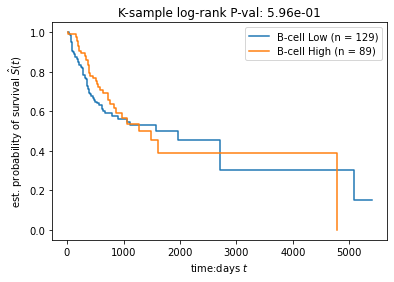

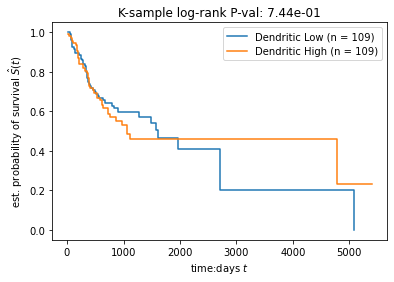

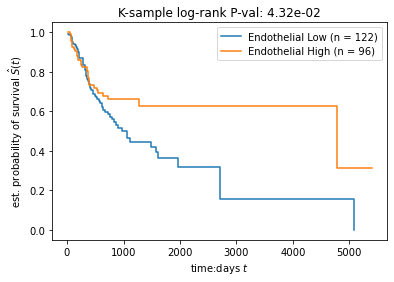

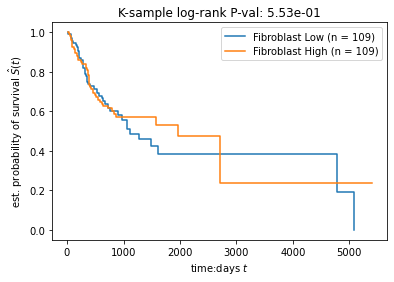

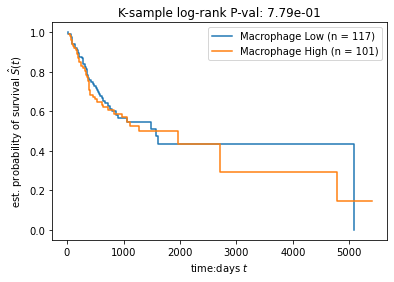

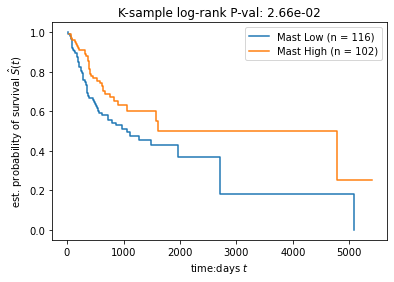

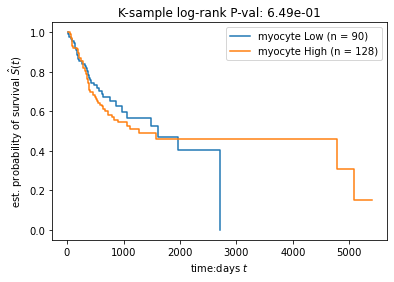

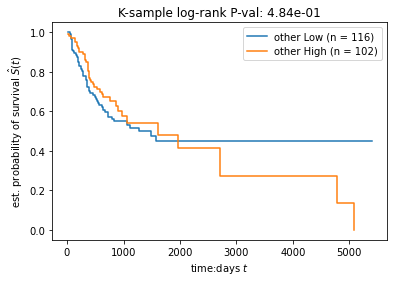

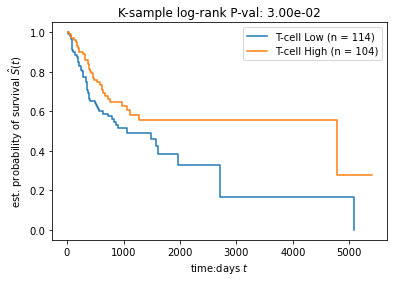

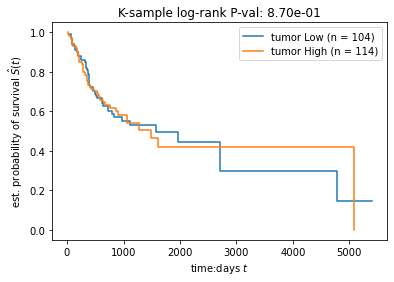

In [53]:
# major cell types
for i in df_merged_HPVneg.columns[:10]:
    df_merged_nonrelative_sorted = df_merged_HPVneg.sort_values(i)
    df_merged_nonrelative_sorted[i+' group']=''
    df_merged_nonrelative_sorted[i+' group'][:int(len(df_merged_nonrelative_sorted)/2)]=i+' Low'
    df_merged_nonrelative_sorted[i+' group'][int(len(df_merged_nonrelative_sorted)/2):]=i+' High'
    fig = plt.subplots()
    chisq,pval = Survival_kmCurve(df_merged_nonrelative_sorted[df_merged_nonrelative_sorted['primary_site']=='Oral Cavity'],i+' group',)
    print(chisq,pval)

/tmp/ipykernel_32099/2797385280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_subtypes_nonrelative_sorted[i+' group'][:int(len(df_merged_subtypes_nonrelative_sorted)/2)]=i+' Low'
/tmp/ipykernel_32099/2797385280.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_subtypes_nonrelative_sorted[i+' group'][int(len(df_merged_subtypes_nonrelative_sorted)/2):]=i+' High'
/tmp/ipykernel_32099/2797385280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

B-cells group=B-cells Low    0.152087
dtype: float64
0.47873506633943597 0.48899583891300247
CD14-cells group=CD14-cells Low   -0.111455
dtype: float64
0.2774025698748818 0.5984087401404127
CD8-cells group=CD8-cells Low    0.379064
dtype: float64
3.2943598466623962 0.06951820097742013
Endothelial group=Endothelial Low    0.437747
dtype: float64
3.922379621085421 0.04764739116842942


/tmp/ipykernel_32099/2797385280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_subtypes_nonrelative_sorted[i+' group'][:int(len(df_merged_subtypes_nonrelative_sorted)/2)]=i+' Low'
/tmp/ipykernel_32099/2797385280.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_subtypes_nonrelative_sorted[i+' group'][int(len(df_merged_subtypes_nonrelative_sorted)/2):]=i+' High'
/tmp/ipykernel_32099/2797385280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Fibroblast group=Fibroblast Low    0.068725
dtype: float64
0.10803653241589842 0.7423906847770922
Macrophage group=Macrophage Low   -0.193787
dtype: float64
0.8600345322686481 0.35372902815126883
Mast group=Mast Low    0.562014
dtype: float64
6.630241101549326 0.010026169267820975
NK-cells group=NK-cells Low    0.018848
dtype: float64
0.00757598388253821 0.9306396155925917
pDC-cells group=pDC-cells Low    0.46484
dtype: float64
4.696437143201383 0.030225211976216703


/tmp/ipykernel_32099/2797385280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_subtypes_nonrelative_sorted[i+' group'][:int(len(df_merged_subtypes_nonrelative_sorted)/2)]=i+' Low'
/tmp/ipykernel_32099/2797385280.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_subtypes_nonrelative_sorted[i+' group'][int(len(df_merged_subtypes_nonrelative_sorted)/2):]=i+' High'
/tmp/ipykernel_32099/2797385280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Tconv-cell group=Tconv-cell Low   -0.014604
dtype: float64
0.0046939165279374275 0.9453779378687015
Treg-cells group=Treg-cells Low    0.022568
dtype: float64
0.011646075038708365 0.9140615459782842
tumor group=tumor Low   -0.189979
dtype: float64
0.8228096767246813 0.36435996108518987


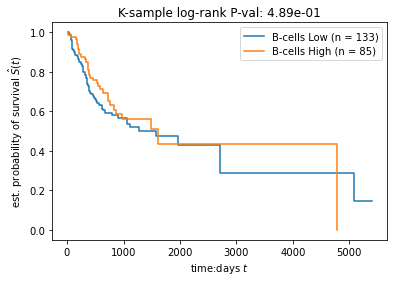

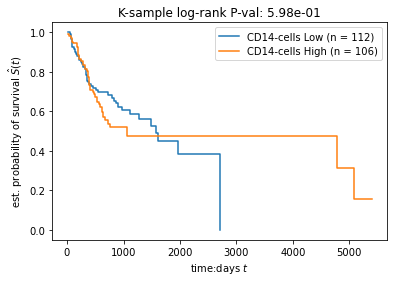

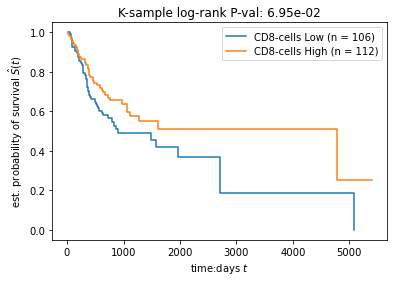

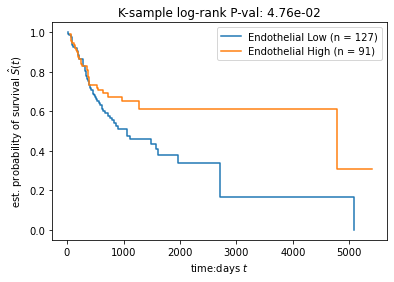

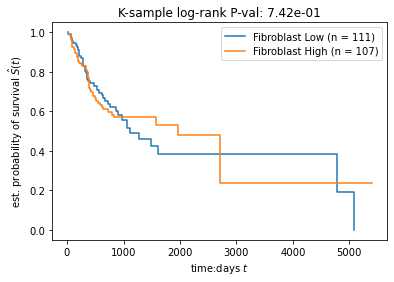

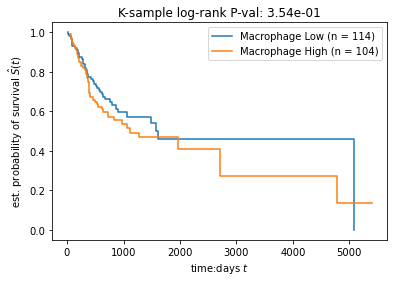

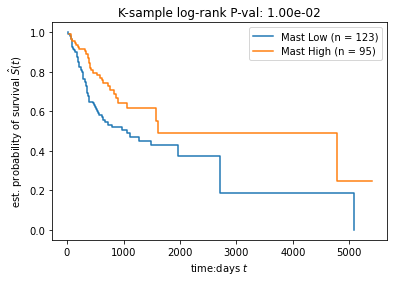

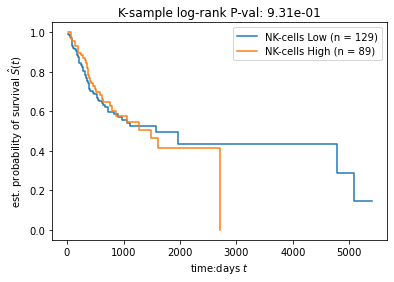

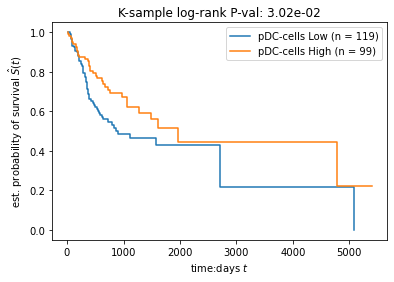

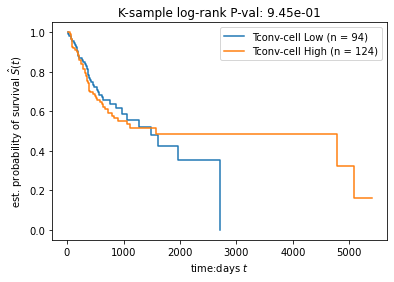

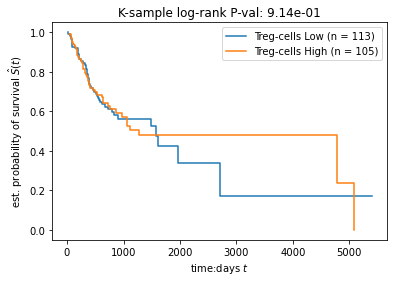

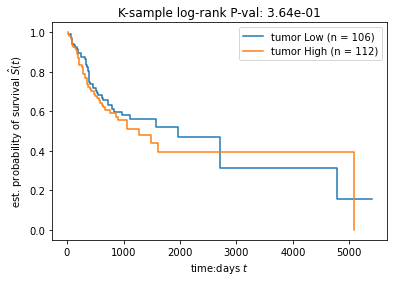

In [54]:
# immune subtypes
# major cell types
for i in df_merged_HPVneg_subtypes.columns[:12]:
    df_merged_subtypes_nonrelative_sorted = df_merged_HPVneg_subtypes.sort_values(i)
    df_merged_subtypes_nonrelative_sorted[i+' group']=''
    df_merged_subtypes_nonrelative_sorted[i+' group'][:int(len(df_merged_subtypes_nonrelative_sorted)/2)]=i+' Low'
    df_merged_subtypes_nonrelative_sorted[i+' group'][int(len(df_merged_subtypes_nonrelative_sorted)/2):]=i+' High'
    fig = plt.subplots()
    chisq,pval = Survival_kmCurve(df_merged_subtypes_nonrelative_sorted[df_merged_subtypes_nonrelative_sorted['primary_site']=='Oral Cavity'],i+' group',)
    print(chisq,pval)

### 3 by 2-setups: Decon results from major cell types and immune subtypes
-	HPV- negative oral cavity CNA-silent vs nonsilent
-	HPV-negative oropharynx vs HPV-positive oropharynx
-	Oral cavity vs larynx vs oropharynx vs hypopharynx (all HPV-negative)

In [48]:
def Survival_kmCurve(df,condition,):
    df = df.dropna()
    list_col = ['Overall Survival Status','Overall Survival (Months)']
    list_col.append(condition)
    df = df.loc[:,list_col]
    df.loc[:,'Overall Survival Status'] = df.loc[:,'Overall Survival Status'].map({'DECEASED':True,'LIVING':False})
    df.loc[:,'Overall Survival (Days)'] = df.loc[:,'Overall Survival (Months)']*30

    data_x,data_y = get_x_y(df,['Overall Survival Status','Overall Survival (Days)'],True)
#     fig = plt.subplots()
    
    for value in data_x[condition].unique():
        mask = data_x[condition] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Overall Survival Status"][mask],
                                                               data_y["Overall Survival (Days)"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (value, mask.sum()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time:days $t$")
    plt.legend(loc="best")
    
    chisq,pval = compare_survival(data_y,data_x[condition])
    
    data_x_numeric = OneHotEncoder().fit_transform(data_x.drop('Overall Survival (Months)',axis=1).astype('category'))
    # print(data_x_numeric.head())

    estimator = CoxPHSurvivalAnalysis()
    estimator.fit(data_x_numeric, data_y)
    plt.title("K-sample log-rank P-val: "+str(f'{pval:.2e}'))

    print(pd.Series(estimator.coef_, index=data_x_numeric.columns))
    return chisq,pval

FGA_status=Silent   -0.009801
dtype: float64
0.001191602292239555 0.9724628188033086


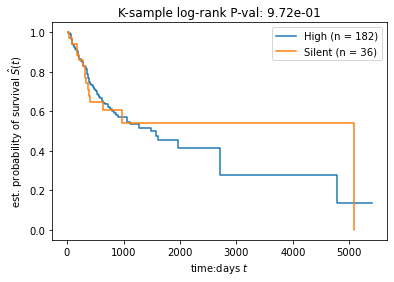

In [14]:
chisq,pval = Survival_kmCurve(df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'],'FGA_status',)
print(chisq,pval)

primary_site=Larynx        -0.470099
primary_site=Oral Cavity   -0.367958
primary_site=Oropharynx    -0.074700
dtype: float64
1.814748554645367 0.6117307563218148


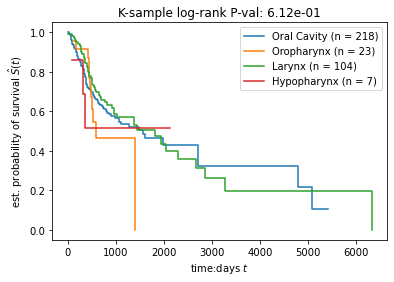

In [15]:
chisq,pval = Survival_kmCurve(df_merged_HPVneg,'primary_site')
print(chisq,pval)

hpv_status=Positive   -2.040584
dtype: float64
15.754687360300702 7.210904804581319e-05


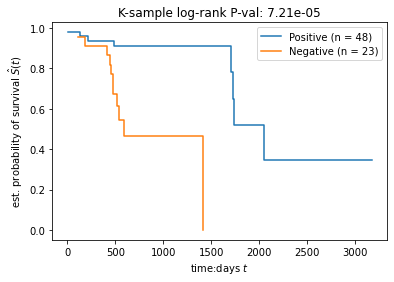

In [16]:
chisq,pval = Survival_kmCurve(df_merged_nonrelative[df_merged_nonrelative['primary_site']=='Oropharynx'],'hpv_status')
print(chisq,pval)

In [130]:
data_x = df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'].dropna()

In [131]:
data_y = df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'].dropna().loc[:,df_tcga_survival.columns[1:]]

In [132]:
data_y.loc[:,'Overall Survival Status'] = data_y['Overall Survival Status'].map({'DECEASED':True,'LIVING':False})

In [133]:
data_y['Overall Survival (Days)'] = data_y['Overall Survival (Months)']*30

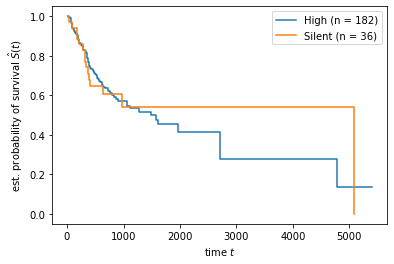

In [135]:
for value in data_x["FGA_status"].unique():
    mask = data_x["FGA_status"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Overall Survival Status"][mask],
                                                           data_y["Overall Survival (Days)"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")